<a href="https://colab.research.google.com/github/chuk-yong/Neo4j-Company-Show-Case/blob/main/Neo4j_Aura_Company_Showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Neo4j Aura
Aura uses AWS for hosting.  Otherwise, interface is similar to using sandbox.


In [1]:
!pip install neo4j

     |████████████████████████████████| 89 kB 3.9 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.1-py3-none-any.whl size=114783 sha256=7cde1093406d2015cb46d69f8a4ce187b2c3682961e3158e5d569528fcd7dd44
  Stored in directory: /root/.cache/pip/wheels/fd/15/02/8379f87426cd1b74fd5891f49df9fb978423feb97650cd639b
Successfully built neo4j


In [2]:
from neo4j import GraphDatabase
uri = "neo4j+s://712b29da.databases.neo4j.io:7687"
user = "neo4j"
password = "cQR5pHLeY7umPm9MGM3gjshjL_VFqYi8V_1x7fA6Rlc"
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

In [4]:
# remember to mount google drive
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/Dept-Person-Role.csv")

In [5]:
#C1='CREATE (p:Person {[Name:df[row.Index]["Person"], Role=df[row.Index]["Role]})-[:belongtoDept]->(d:Department [Name:df[row.Index]["Department])' # use single quote
for row in df.itertuples():
  C1='CREATE (p:Person {Name:"' + row.Person +'", Role:"' + row.Role + '"})-[:belongtoDept]->(d:Department {Name:"' + row.Department +'"})'
  print(C1)
  session.run(C1)

CREATE (p:Person {Name:"Gerard", Role:"Head"})-[:belongtoDept]->(d:Department {Name:"HR"})
CREATE (p:Person {Name:"Rachel", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"HR"})
CREATE (p:Person {Name:"Lee", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"HR"})
CREATE (p:Person {Name:"Jocelyn", Role:"Head"})-[:belongtoDept]->(d:Department {Name:"FIN"})
CREATE (p:Person {Name:"Dorothy", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"LOB"})
CREATE (p:Person {Name:"Albert", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"LOB"})


In [6]:
# Create Approver
app = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/Approver-Person.csv")
def approval_of(tx, name, approver):
    tx.run("MATCH (a:Person) WHERE a.Name = $name "
           "MERGE (a)-[:seekApproval]->(:Approver {Name: $approver})",
           name=name, approver=approver)

for row in app.itertuples():
  with session as sess:
      sess.write_transaction(approval_of, row.Person, row.Approver)

In [7]:
# Create Case
case = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/Person-CaseID-Desc.csv")
def has_case(tx, name, caseID, desc):
    tx.run("MATCH (a:Person) WHERE a.Name = $name "
           "MERGE (a)-[:hasCase]->(:Case {CaseID: $caseID,CaseDescription: $desc})",
           name=name, caseID=caseID, desc=desc)

for row in case.itertuples():
  with session as sess:
    sess.write_transaction(has_case, row.Person, row.CaseID, row.CaseDescription)

In [8]:
# Create Action
action = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/CaseID-Action-Status.csv")
def has_action(tx, case, action, status):
    tx.run("MATCH (a:Case) WHERE a.CaseID = $case "
           "MERGE (a)-[:hasAction]->(:Action {Action: $action, Status: $status})",
           case=case, action=action, status=status)

for row in action.itertuples():
  with session as sess:
    sess.write_transaction(has_action, row.CaseID, row.Action, row.Status)

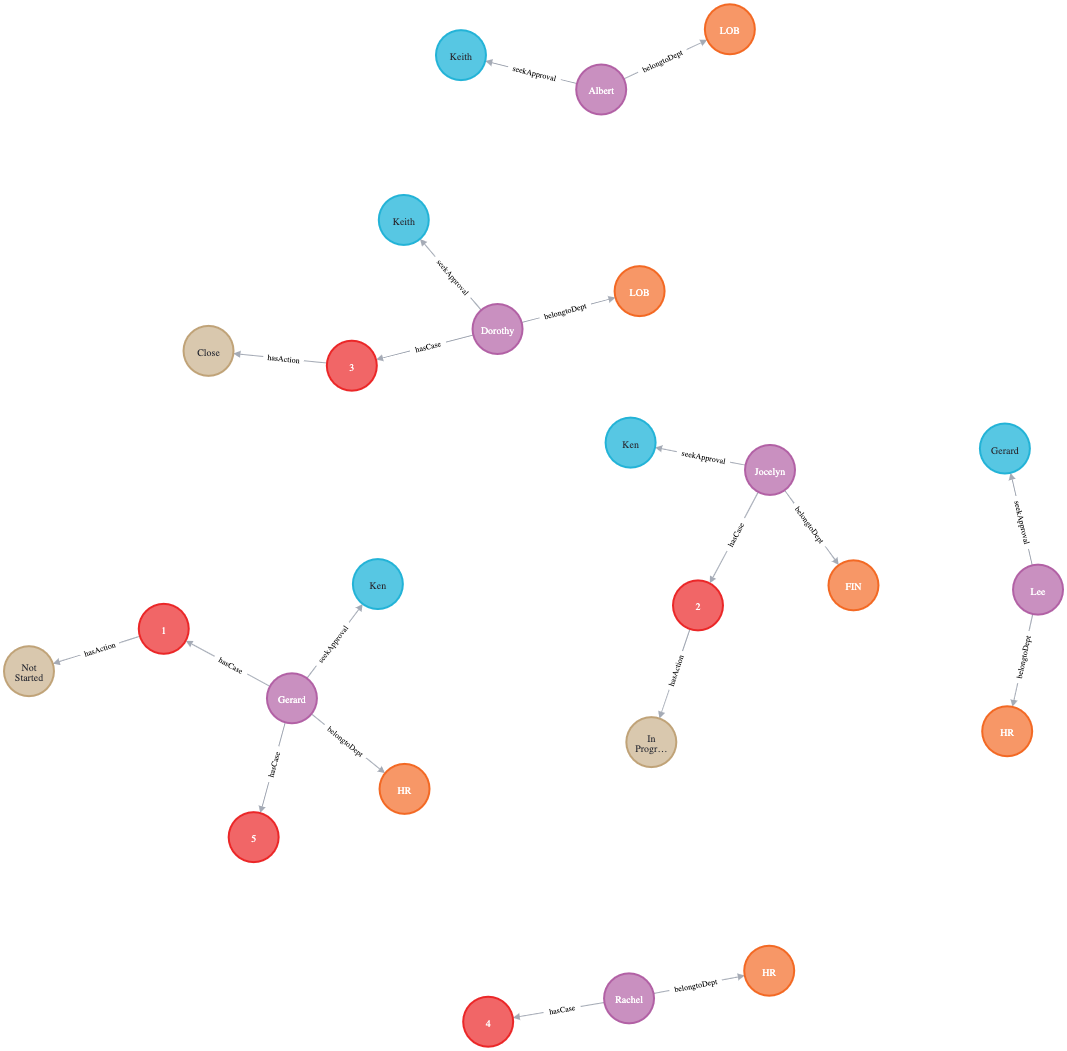

## Queries

In [9]:
# Query headcount.  How many people are there in LOB department?
q = 'match (n:Department) where n.Name = "LOB" return count(n)'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results)

[{'count(n)': 2}]


In [10]:
# Query case count by department. How many case load are there for HR department?
q = 'match ()<-[:hasCase]-(n:Person)-[:belongtoDept]->(Department {Name:"HR"}) return count(distinct n)'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results)

[{'count(distinct n)': 2}]


In [11]:
# approval office.  Who is Rachel's Boss?
q = 'match (Person {Name:"Rachel"})-[:seekApproval]->(a:Approver) return a.Name'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results) # Rachel has no approver

[]


In [12]:
# Alternative, Who is the head of Rachel's department
q = 'match (Person {Name:"Rachel"})-[:belongtoDept]->(d:Department) with d.Name as dept match (p:Person {Role:"Head"})-[belongtoDept]->(Department {Name:dept}) return p.Name'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results)

[{'p.Name': 'Gerard'}]


## Writing tx.run
* white space at the end of sentence except the last
* need to pass the variable into tx.run again

In [45]:
def count_action(tx, dept):
    query = (
        "MATCH (p:Person)-[:belongtoDept]->(d:Department {Name:$dept}) "
        "WITH p.Name AS name "
        "Match (Person {Name:name})-[:hasCase]->(c:Case) "       
        "WITH c.CaseID AS id "
        "Match (Case {CaseID:id})-[:hasAction]->(act:Action) "
        "WITH apoc.agg.maxItems(act, act.Action) AS result "
        "RETURN result.items AS action result.value AS count"
    )
    q = (
        "MATCH (p:Person)-[:belongtoDept]->(d:Department {Name:$dept}) "
        "WITH p.Name AS name "
        "Match (Person {Name:name})-[:hasCase]->(c:Case) "       
        "WITH c.CaseID AS id "
        "Match (Case {CaseID:id})-[:hasAction]->(act:Action) "
        "RETURN act.Action"
    )  
    result = tx.run(q, dept=dept)
    for record in result:
      print(record["act.Action"])
    

with session as sess:
  sess.write_transaction(count_action, "HR")

Find Resource
Brand Marketing
Find Resource
